<h1>Анализ формулы один с использованием методов машинного обучения и математической статистики</h1>

<h2>Первоначальной нашей целью будет прогноз вероятности совершения обгона на каждом из участков трассы.</h2>

<h3>Этап первый: определение обгонов</h3>

In [32]:
import fastf1 as ff1
import pandas as pd
import numpy as np
import math
import requests
from scipy import stats

selected_season = 2020
selected_race = 10

ff1.Cache.enable_cache('cache')
session = ff1.get_session(selected_season, selected_race, 'R')
quali = ff1.get_session(selected_season, selected_race, 'Q')
quali.load()
quali = quali.results

core           INFO 	Loading data for Russian Grand Prix - Qualifying [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '3', '55', '31', '4', '10', '23', '16', '26', '18', '63', '5', '8', '99', '20', '6', '7']


In [33]:
quali

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
44,44,L HAMILTON,HAM,Mercedes,00D2BE,Lewis,Hamilton,Lewis Hamilton,1.0,0.0,0 days 00:01:32.983000,0 days 00:01:32.835000,0 days 00:01:31.304000,NaT,,0.0
33,33,M VERSTAPPEN,VER,Red Bull Racing,1E41FF,Max,Verstappen,Max Verstappen,2.0,0.0,0 days 00:01:33.630000,0 days 00:01:33.157000,0 days 00:01:31.867000,NaT,,0.0
77,77,V BOTTAS,BOT,Mercedes,00D2BE,Valtteri,Bottas,Valtteri Bottas,3.0,0.0,0 days 00:01:32.656000,0 days 00:01:32.405000,0 days 00:01:31.956000,NaT,,0.0
11,11,S PEREZ,PER,Racing Point,F596C8,Sergio,Perez,Sergio Perez,4.0,0.0,0 days 00:01:33.704000,0 days 00:01:33.038000,0 days 00:01:32.317000,NaT,,0.0
3,3,D RICCIARDO,RIC,Renault,FFF500,Daniel,Ricciardo,Daniel Ricciardo,5.0,0.0,0 days 00:01:33.650000,0 days 00:01:32.218000,0 days 00:01:32.364000,NaT,,0.0
55,55,C SAINZ,SAI,McLaren,FF8700,Carlos,Sainz,Carlos Sainz,6.0,0.0,0 days 00:01:33.967000,0 days 00:01:32.757000,0 days 00:01:32.550000,NaT,,0.0
31,31,E OCON,OCO,Renault,FFF500,Esteban,Ocon,Esteban Ocon,7.0,0.0,0 days 00:01:33.557000,0 days 00:01:33.196000,0 days 00:01:32.624000,NaT,,0.0
4,4,L NORRIS,NOR,McLaren,FF8700,Lando,Norris,Lando Norris,8.0,0.0,0 days 00:01:33.804000,0 days 00:01:33.081000,0 days 00:01:32.847000,NaT,,0.0
10,10,P GASLY,GAS,AlphaTauri,ffffff,Pierre,Gasly,Pierre Gasly,9.0,0.0,0 days 00:01:33.734000,0 days 00:01:33.139000,0 days 00:01:33,NaT,,0.0
23,23,A ALBON,ALB,Red Bull Racing,1E41FF,Alexander,Albon,Alexander Albon,10.0,0.0,0 days 00:01:33.919000,0 days 00:01:33.153000,0 days 00:01:33.008000,NaT,,0.0


In [34]:
session.load(laps=True, telemetry=True)
laps = session.laps

core           INFO 	Loading data for Russian Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '44', '11', '3', '16', '31', '26', '10', '23', '99', '20', '5', '7', '4', '6', '8', '63', '55', '18']


In [36]:
laps['LapEndTime'] = laps['LapStartTime'] + laps['LapTime']

Сделаем подготовку данных для просчета обгонов
Отберем для каждого гонщика те записи, где менялся гонщик впереди, аналогичные же записи отберем для других гонщиков

<h3> Дальнейшая работа и алгоритм вычисления места обгона </h3>
Алгоритм следующий: для каждого гонщика считается его текущая позиция в каждый момент предполагаемого обгона. Обгон засчитывается, если позиция не была возвращена до конца круга, аналогично в дальнейших версиях алгоритма стоит исключить обгоны из-за заездов на питстоп. Таким образом, алгоритм будет следующим:
<ol style="color: green">
<li>Посчитать сетку на конец круга</li>
<li>Найти смены позиций, если таковые были</li>
<li>Найти где была произведена окончательная смена позиций</li>
<li style="color: red">Выделить места борьбы за место</li>
</ol>

Что считается обгоном: <a href="https://www.motorsport.com/f1/news/overtaking-records-in-f1-most-overtakes-in-a-race-by-a-driver/6718440/">motorsport.com</a>

Чуть более подробно по пунктам:
Первоначальная расстановка берется исходя из квалификации ( данный момент в процессе доработки, т.к. после квалификации перед гонкой могут происходить перестановки )
Далее алгоритм:
1. Берется расстановка на начало круга ( конец предыдущего ) и конец круга
2. Вычисляется массив вида: a = <a style="color: yellow">[1, -1, 0, 2, 0, -2 ... ]</a>, где в каждой ячейке стоит число n - количество потерянных / выигранных позиций относительно начала круга.
3. Находится первый отрицательный элемент в массиве, назовем его <i>x</i>, тогда предыдущие abs(<i>x</i>) элементов - гонщиков, которые пропустили нашего, у предыдущих <i>x</i> элементов вычитается по единице, сам элемент x обнуляется
4. вычисляются <i>x</i> гонщиков впереди, далее: y - рассматриваемый обогнавший гонщик, количество возможных значений <i>y</i>: abs(<i>x</i>)
5. ищется наименьшее время, когда для обгоняемого гонщика ( с <i>x</i> потерянных позиций ), гонщик <i>y</i> оказался впереди, берется X и Y этой позиции и записывается один обгон

Пример:
[22, 11, 10] - номера гонщиков и их расположение на начало круга
[10, 11, 22] - номера гонщиков и их расположение на конец круга

тогда нужный нам массив смены мест:
[2, 0, -2],
первый отрицательный элемент = -2, тогда:
1. ищем обгон 22'ого гощника 10'ым
2. ищем обгон 22'ого гонщика 11'ым

массив смены мест после этого:
[1, -1, 0]
Первый отрицательный элемент = -1, тогда:
1. ищем обгон 11'ого гонщика 10'ым

<a style="color: grey"> Под поиском обгона подразумевается алгоритм нахождения под пунктом 5, а именно выделение наименьшего времени</a>

In [ ]:
laps[((laps['PitOutTime'].notna()) | (laps['PitInTime'].notna())) & (laps['DriverNumber'] == '33')]

In [ ]:
laps.pick_driver("44").get_telemetry()

In [315]:
def get_starting_grid(season, race):
    race_results = requests.get(f'http://ergast.com/api/f1/{season}/{race}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
    df_drivers = pd.DataFrame(race_results['Driver'].tolist())
    
    return np.array(race_starting)

def calculate_lap_grid(data, lap_num):
    return data[data['LapNumber'] == lap_num].sort_values(by=['LapEndTime'])

def get_position_of_overtake(data, overtaken_driver, driver):
    driver_data = data.pick_driver(overtaken_driver).get_telemetry()
    index = driver_data[driver_data['DriverAhead'] == driver].index.min()
    if np.isnan(index):
        return [None, None]
    else:
        driver_row = driver_data.loc[[index]].iloc[0]
        # данные достаточно плохого качества, зачастую PitOutTime не указан
        if len(data[(data['DriverNumber'] == overtaken_driver) & (data['PitInTime'] <= driver_row['SessionTime']) & (data['PitInTime'] + pd.Timedelta(seconds=80) >= driver_row['SessionTime'])]) == 0:
            return [driver_row['X'], driver_row['Y']]
        else:
            logging.info("Overtake during pit")
            return [None, None]

def find_and_process_overtake(grid_to_process, data, lap_number):
    overtaken_driver = grid_to_process[-1]
    lap_data = data[data['LapNumber'] == lap_number]
    overtakes = []
    for driver in grid_to_process[:-1]:
        x, y = get_position_of_overtake(lap_data, overtaken_driver, driver)
        if x is not None:
            overtakes.append([x, y])
    return overtakes

def calculate_overtakes_for_lap(grid_to_process, difference_in_grid, data, lap_number):
    overtakes_to_find = []
    i = 0
    while i < len(difference_in_grid):
        if difference_in_grid[i] < 0:
            overtakes_to_find += (find_and_process_overtake(grid_to_process[i + difference_in_grid[i]:i + 1], data, lap_number))
            difference_in_grid[i + difference_in_grid[i]:i] += np.full(len(difference_in_grid[i + difference_in_grid[i]:i]), -1)
            difference_in_grid[i] = 0
            difference_in_grid = np.array(list(difference_in_grid[:i + difference_in_grid[i]]) + list(difference_in_grid[i + difference_in_grid[i]:i]) + list(difference_in_grid[i:]))
            i += difference_in_grid[i] - 1
        i += 1
    return overtakes_to_find

In [317]:
# увы, пока мы не умеем получать настоящую расстановку на начало гонки
def calculate_overtakes_during_race(laps, season, race):
    previous_grid = get_starting_grid(season, race)
    overtakes = []
    for i in range(1, int(laps['LapNumber'].max()) + 1):
        transition_grid = dict(zip(previous_grid, np.arange(1, len(previous_grid) + 1)))
        current_grid = calculate_lap_grid(laps, i)['DriverNumber'].to_list()
        previous_grid = current_grid
        current_grid = np.array([transition_grid[driver] for driver in current_grid])
        difference = current_grid - np.array(sorted(current_grid))
        overtakes += calculate_overtakes_for_lap(previous_grid, difference, laps, i)
    return overtakes

overtakes = calculate_overtakes_during_race(laps, session, selected_race)

<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit
<ipython-input-315-7b97d539ff2b>       INFO 	Overtake during pit


In [310]:
overtakes

[[249, -2014],
 [-7716, -6376],
 [-4846, -5560],
 [-5033, -5609],
 [203, -2099],
 [-2091, -4708],
 [-6440, -5997],
 [507, -1610],
 [248, -2028],
 [-1270, -4142],
 [-9713, -4811],
 [816, -1114],
 [770, -1189],
 [-5861, -5832],
 [-9131, -5280],
 [-3827, -5295],
 [-7930, -6431],
 [-9031, -5380],
 [1168, -581],
 [1085, -707],
 [-3564, -3401],
 [1110, -669],
 [1093, -696],
 [1076, -720],
 [1111, -667],
 [1074, -724],
 [-12169, -7645],
 [-3632, -3400],
 [-6398, -5983],
 [1090, -700],
 [-1599, -1679],
 [-2425, -4391],
 [-12129, -7711],
 [-1150, -4030],
 [-3687, -5257],
 [-3118, -4160],
 [-10982, -4527],
 [-6163, -5915],
 [-7103, -6194],
 [394, 882],
 [771, -857],
 [514, -1263],
 [479, -1318],
 [250, -1682],
 [335, -1546],
 [-191, -2383],
 [-12444, -7171],
 [-2069, -4237],
 [1076, -373],
 [1048, -416],
 [1049, -417],
 [1049, -417],
 [1048, -416],
 [811, -793],
 [331, -1553],
 [-426, -2754],
 [1100, -682],
 [1101, -334],
 [692, -981],
 [456, -1356],
 [225, -1722],
 [137, -1860],
 [621, 786],
 [

## Посмотрим на визуализацию мест обгонов на одной конкретной трассе за разные года. Для этого выберем трассу которая не менялась с 2014 года.
 <i style="color: #ff2800"> небольшое уточнение, все координаты представлены в 1/10 метра, мы разделим всю трассу на зоны

In [311]:
x_size_of_sector = 50
y_size_of_sector = 50

<h2> Давайте создадим нашу трассу </h2>

In [313]:
def num_of_overtakes_in_segment(point, overtakes_df):
    return len(overtakes_df[(overtakes_df['X'] == math.floor(point['X'] // 10  // x_size_of_sector)) & (overtakes_df['Y'] == math.floor(point['Y'] // 10 // y_size_of_sector))])

lap = laps.pick_fastest()
tel = lap.get_telemetry()

x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

overtakes_to_display = pd.DataFrame({"X": x, "Y": y})
overtakes_to_process = pd.DataFrame({"X": [x[0] for x in overtakes], "Y": [x[1] for x in overtakes]})
overtakes_to_process['X'] = overtakes_to_process['X'].apply(lambda i: math.floor(i // 10  // x_size_of_sector))
overtakes_to_process['Y'] = overtakes_to_process['Y'].apply(lambda i: math.floor(i // 10  // x_size_of_sector))
overtakes_to_display['nOvertakes'] = overtakes_to_display.apply(lambda i: num_of_overtakes_in_segment(i, overtakes_to_process), axis=1)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

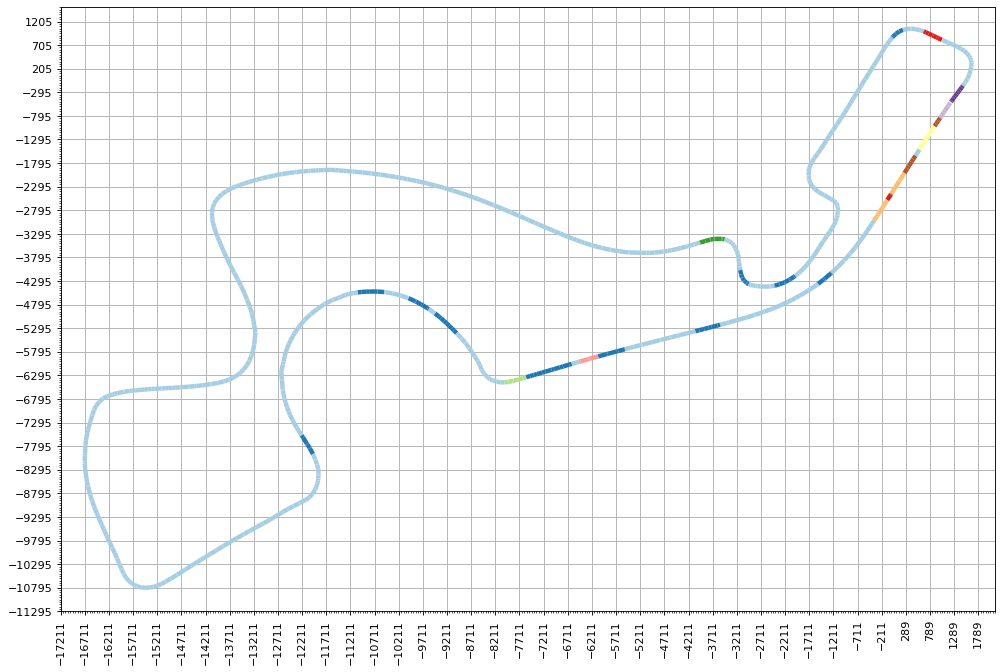

In [314]:
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.pyplot as plt

max_x = overtakes_to_display['X'].max() + 500
min_x = overtakes_to_display['X'].min() - 500
max_y = overtakes_to_display['Y'].max() + 500
min_y = overtakes_to_display['Y'].min() - 500

fig,ax = plt.subplots(figsize=(10 * (max_x + abs(min_x)) / (max_y + abs(min_y)), 10), dpi=80)

overtake = overtakes_to_display['nOvertakes'].to_numpy().astype(float)

cmap = cm.get_cmap('Paired')
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(overtake)
lc_comp.set_linewidth(4)
ax.add_collection(lc_comp)

major_ticks_x = np.arange(min_x, max_x, 10 * x_size_of_sector)
minor_ticks_x = np.arange(min_x, max_x, x_size_of_sector)

major_ticks_y = np.arange(min_y, max_y, 10 * y_size_of_sector)
minor_ticks_y = np.arange(min_y, max_y, y_size_of_sector)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
plt.grid()
plt.xticks(rotation=90)
plt.show()

Попробуем получить настоящие данные трасс ( увы, дальнейшее использование невозможно т.к. датасет не содержит все нужные треки, но он достоин упомянания:
<a href="https://github.com/TUMFTM/racetrack-database"> github.com </a>

In [43]:
map_data = pd.read_csv("Monza.csv")
map_data.rename(columns={"# x_m": "x_m"}, inplace=True)

<ipython-input-44-63169f991a4a>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


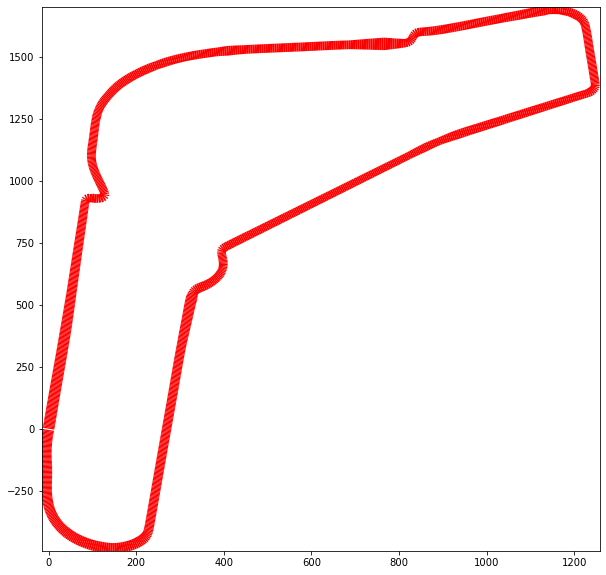

In [44]:
x = map_data['x_m']
y = map_data['y_m']
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, linewidths=map_data['w_tr_left_m'] + map_data['w_tr_right_m'], color='red')
fig, a = plt.subplots(figsize=[10, 10])
a.add_collection(lc)
a.set_xlim(x.min() - 10, x.max() + 10)
a.set_ylim(y.min() - 10, y.max() + 10)
fig.show()

Предполагаемое описание алгоритма:
<ol style="color: red">
<li>Выделить только первые записи для каждого сектора</li>
<li>Посчитать была ли смена позиций в конце сектора</li>
<li>Добавить среднюю скорость на секторе, скорость автомобиля впереди, среднее кол-во обгонов на секторе за круг</li>
</ol>

Что важно отметить:
Мы уберем упомянание команды и гонщика из выборки, вот по каким причинам: из года в год значимость команды меняется, то, что мерседес доминировали в 2019 году не дает никаких гарантий на последующие гонки. Введём альтернативу: позиция команды в кубке конструкторов и позиция гонщика в общем зачете на данный момент

Нами был сформирован достаточно обширный датасет хранящий в себе данный о гонщике и данные о гонщике впереди, мы попытаемся предсказать был ли обгон в конце сектора по началу сектора

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve

data = pd.read_csv("complete_df_2021_1.csv")
data = data.append(pd.read_csv("complete_df_2021_2.csv"))
data = data.append(pd.read_csv("complete_df_2021_3.csv"))
data = data.append(pd.read_csv("complete_df_2021_4.csv"))
data = data.append(pd.read_csv("complete_df_2021_5.csv"))
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
X = data.drop(columns=['Overtake', 'Status', 'SessionTime', 'Date', 'Source', 'Time'])
y = data['Overtake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [279]:
from sklearn.model_selection import RandomizedSearchCV

def search_best_params(X_df, y_df):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']

    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)

    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='precision',refit='precision', n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_df, y_df)
    return rf_random

In [47]:
clf = RandomForestClassifier(n_estimators= 800, min_samples_split= 2, min_samples_leaf = 1, max_features='auto',max_depth=100, bootstrap= True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test), precision_recall_curve(y_pred, y_test))

0.8411552346570397 0.9662616114707094 0.758957654723127 0.9433198380566802 (array([0.03478383, 0.75895765, 1.        ]), array([1.        , 0.94331984, 0.        ]), array([0., 1.]))


Общая идея алгоритма: мы предсказываем вероятность обгона на каждом отдельном участке, если вероятность обгона выросла -> мы даем гонщику очки, если вероятность понизилась - забираем. Если гонщик совершил обгон - добавляем 1 - вероятность обгона, если гонщика обогнали, то из его очков вычитаем 1 - вероятность обгона, назовем этот параметр adv: attack-defence value. Аналогично, в дальнейшем планируется добавить возможность оценивать атаку и оборону отдельно.
В дальнейшем планируется комплексно оценивать и другие действия пилотов.

reference model: <a href="https://statsbomb.com/articles/soccer/introducing-on-ball-value-obv/"> statsbomb obv </a>

In [48]:
y_proba = clf.predict_proba(X)
X['probability_of_overtake'] = y_proba[:, 1]
X['points_gained'] = np.zeros(len(X))

In [49]:
for driver in X['DriverNumber'].unique():
    driver_df = X[X['DriverNumber'] == driver].copy()
    driver_df['points_gained'] = driver_df['probability_of_overtake'].diff()
    X.loc[X['DriverNumber'] == driver, 'points_gained'] = driver_df['points_gained']

X['points_gained'] = X['points_gained'].fillna(0)

На данном этапе мы имеем датафрейм,который содержит подробную информацию о кругах, которые гонщик совершил в квалификации, теперь давайте сформируем данные, которые мы будем анализировать, а именно - результаты квалификации. Мы хотим добавить следующие параметры:
- adv гонщика на данной трассе за все время
- adv гонщика в сезоне
- является ли гонка домашней
- положение гонщика в общем зачете
- положение команды в общем зачете

<h3>Предскажем результат гонки по результату квалификации без использования метрики</h3>

Для начала получим национальности гонщиков и команд. Это может быть важно, так как когда мы говорим о спорте нельзя не учитывать психологический эффект

In [128]:
import logging

def get_circuit(season, race):
    request = requests.get(f'http://ergast.com/api/f1/{season}/{race}/circuits.json').json()['MRData']['CircuitTable']['Circuits'][0]
    return {"country": request['Location']['country'], "circuit_name": request['circuitName']}

In [184]:
def get_driver_points(race_results, driver):
    try:
        return race_results.loc[driver['name']]['points']
    except KeyError:
        return 0

def get_standings(season, race,  drivers, constructors):
    constructors_standings = pd.DataFrame({
        'name': constructors.index,
        'points': np.zeros(len(constructors)),
    })
    drivers_standings = pd.DataFrame({
        'name': drivers.index,
        'points': np.zeros(len(drivers)),
    })
    for r in range(1, race):
        while True:
            try:
                race_results = requests.get(f'http://ergast.com/api/f1/{season}/{r}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
                break
            except Exception as e:
                logging.error(e)

        race_results = pd.DataFrame.from_dict(race_results)
        if 'FastestLap' in race_results.columns:
            race_results.drop(columns=['FastestLap'], inplace=True)
        race_results['constructor'] = race_results['Constructor'].apply(lambda constructor: constructor['name'])
        race_results['driverCode'] = race_results['Driver'].apply(lambda driver: driver['code'])
        race_results.drop(columns=['Constructor', 'Time', 'status', 'laps', 'positionText', 'Driver', 'grid'], inplace=True)
        race_results['number'] = race_results['number'].astype(str)
        race_results = race_results.set_index(['driverCode'])
        race_results['points'] = race_results['points'].astype(float)

        drivers_standings['points'] = drivers_standings.apply(lambda driver:
                                                                        driver['points'] + get_driver_points(race_results, driver), axis=1)
        constructors_standings['points'] = constructors_standings.apply(lambda constructor:
                                                                        constructor['points'] + race_results[race_results['constructor'] == constructor['name']]['points'].sum(), axis=1)

    return drivers_standings, constructors_standings

In [181]:
def process_api_response(response):
    results = pd.DataFrame.from_dict(response)
    df_drivers = pd.DataFrame(results['Driver'].tolist())
    df_constructor = pd.DataFrame(results['Constructor'].tolist())
    df_constructor.rename(columns={'nationality': 'team_nationality'}, inplace=True)
    results = pd.concat([results, df_drivers, df_constructor], axis=1)
    results.drop(columns=['Driver', 'Constructor', 'positionText', 'status', 'Time', 'FastestLap', 'url', 'givenName', 'familyName', 'dateOfBirth', 'permanentNumber'], inplace=True,  errors='ignore')
    return results.set_index(['code'])

In [332]:
def get_session_dataframe(season, race):
    # гонщики
    drivers = requests.get(f'http://ergast.com/api/f1/{season}/{race}/drivers.json').json()['MRData']['DriverTable']['Drivers']
    if len(drivers) == 0:
        return None, "season or race not found"
    drivers = pd.DataFrame.from_dict(drivers)
    drivers.drop(columns=['url', 'driverId', 'permanentNumber'], inplace=True)
    drivers = drivers.set_index(['code'])

    # национальности - страна
    nationalities = pd.read_csv('countries.csv')
    nationalities.drop(columns=['CCA2', 'CCA3'], inplace=True)
    nationalities = nationalities.set_index('Name').T.to_dict('records')[0]

    # конструкторы
    constructors = requests.get(f'http://ergast.com/api/f1/{season}/{race}/constructors.json').json()['MRData']['ConstructorTable']['Constructors']
    constructors = pd.DataFrame.from_dict(constructors)
    constructors.drop(columns=['url', 'constructorId'], inplace=True)
    constructors = constructors.set_index(['name'])

    drivers_standings, constructors_standings = get_standings(selected_season, selected_race, drivers, constructors)
    constructors_standings = constructors_standings.set_index(['name'])
    drivers_standings = drivers_standings.set_index(['name'])

    circuit = get_circuit(season, race)
    circuit_country, circuit_name = circuit['country'], circuit['circuit_name']

    quali_data = pd.DataFrame({
        'DriverAbbreviation': [],
        'Team': [],
        'IsAtHomeDriver': [],
        'IsAtHomeTeam': [],
        'ConstructorsStandingPercentile': [],
        'DriversChampionshipPercentile': [],
        'QualiPlace': [],
        'StartingGridPlace': [],
        'ClearWeather': [],
        'LightRainWeather': [],
        'HeavyRainWeather': [],
        'Circuit' : [],
        'Season' : [],
        'Race' : [],
        'RaceResults': []
    })

    try:
        track_country_nationality = nationalities[circuit_country]
    except KeyError:
        track_country_nationality = None

    # получаем и обрабатываем результаты квалификации из api
    quali_results = requests.get(f'http://ergast.com/api/f1/{season}/qualifying/{race}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
    quali_results = process_api_response(quali_results)

    # получаем результаты гонки из api
    race_results = requests.get(f'http://ergast.com/api/f1/{season}/{race}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
    race_results = process_api_response(race_results)
    try:
        race_session = ff1.get_session(season, race, 'R')
        race_session.load(weather=True)
        weather_clear = not race_session.weather_data['Rainfall'].any()
        weather_h_rain = race_session.weather_data['Rainfall'].all()
        weather_l_rain = race_session.weather_data['Rainfall'].any() and not weather_h_rain

    except Exception as _:
        weather_clear = False
        weather_h_rain = False
        weather_l_rain = False

    for index, driver in drivers.iterrows():
        try:
            driver_row = quali_results.loc[index]
            drivers_place = int(driver_row['position'])
        except KeyError:
            logging.error("driver not found")
            break

        driver_team = driver_row['name']
        data = [index,
                driver_team,
                track_country_nationality == driver['nationality'],
                constructors.loc[driver_team]['nationality'] == track_country_nationality,
                stats.percentileofscore(constructors_standings['points'], constructors_standings.loc[driver_team]['points']) / 100,
                stats.percentileofscore(drivers_standings['points'], drivers_standings.loc[index]['points']) / 100,
                drivers_place,
                int(race_results.loc[index]['grid']),
                weather_clear,
                weather_l_rain,
                weather_h_rain,
                circuit_name,
                season,
                race,
                int(race_results.loc[index]['position']),
                ]
        quali_data = pd.concat([pd.DataFrame([data], columns=quali_data.columns), quali_data], ignore_index=True)
    return quali_data, None

total_df = pd.DataFrame({
    'DriverAbbreviation': [],
    'Team': [],
    'IsAtHomeDriver': [],
    'IsAtHomeTeam': [],
    'ConstructorsStandingPercentile': [],
    'DriversChampionshipPercentile': [],
    'QualiPlace': [],
    'ClearWeather': [],
    'LightRainWeather': [],
    'HeavyRainWeather': [],
    'Circuit' : [],
    'Season' : [],
    'Race' : [],
    'RaceResults': [],
})



for year in range(2021, 2009, -1):
    for race in range(1, 23):
        logging.info(f"{year}, {race} - started")
        new_df, error = get_session_dataframe(year, race)
        if year > 2017:
            overtakes = calculate_overtakes_during_race(laps, year, race)
            new_df['AverageNumOfOvertakesOnTrack'] =
        if error is not None:
            if error == "season or race not found":
                break
            print(error)
        else:
            total_df = pd.concat([new_df, total_df], ignore_index=True)

print(total_df)

SyntaxError: invalid syntax (<ipython-input-332-58cc70e05c6e>, line 123)

In [266]:
total_df_dummies = total_df.drop(columns=['DriverAbbreviation', 'Team'])
total_df_dummies = total_df_dummies.join(pd.get_dummies(total_df_dummies.select_dtypes(include=['object'])))
total_df_dummies.drop(columns=total_df_dummies.select_dtypes(include=['object']).columns, inplace=True)
train = total_df_dummies[total_df_dummies['Season'] < 2019]
test = total_df_dummies[total_df_dummies['Season'] > 2018]

X_train = train.drop(columns=['RaceResults'])
X_test = test.drop(columns=['RaceResults'])
y_train = train['RaceResults'] == 1
y_test = (test['RaceResults'] == 1).astype(int)

In [271]:
def transform_predictions(X_test, y_pred):
    X_preds = X_test.copy()
    X_preds['win_proba'] = y_pred[:, 1]
    for name, group in X_preds.groupby(['Season', 'Race']):
        X_preds.loc[(X_preds['Season'] == name[0]) & (X_preds['Race'] == name[1]), 'winner'] = X_preds[(X_preds['Season'] == name[0]) & (X_preds['Race'] == name[1])]['win_proba'] == max(group['win_proba'])
    y_pred = X_preds['winner'].astype(int)
    return y_pred

In [280]:
clf_searched = search_best_params(X_train, y_train)
clf = clf_searched.best_estimator_
y_pred = clf.predict_proba(X_test)
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


(0.43103448275862066,
 0.6903407733116667,
 0.45454545454545453,
 0.4098360655737705)

In [275]:
clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=90, bootstrap=False)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

(0.5087719298245613,
 0.7331535945026221,
 0.5272727272727272,
 0.4915254237288136)

In [319]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

(0.24561403508771928,
 0.5987604596491806,
 0.2545454545454545,
 0.23728813559322035)